In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os
import pandas as pd
import seaborn as sns

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# for pretty printing
def printDf(sprkDF): 
    newdf = sprkDF.toPandas()
    from IPython.display import display, HTML
    return HTML(newdf.to_html())

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Spark libs
from pyspark.sql.session import SparkSession

# helper functions
from helpers.helper_functions import translate_to_file_string

In [2]:
from pyspark.sql.session import SparkSession
from pyspark.sql.types import BooleanType
from pyspark.sql.functions import expr
from pyspark.ml.stat import Summarizer
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler, StringIndexer, StandardScaler
from helpers.helper_functions import translate_to_file_string

In [3]:
inputFile = translate_to_file_string("../data/Flight_Delay_Jan_2020_ontime.csv")

In [4]:
spark = (SparkSession
       .builder
       .appName("FlightDataStatistics")
       .getOrCreate())

In [5]:
pysparkDF = spark.read.option("header", "true") \
        .option("inferSchema", "true") \
        .option("delimiter", ",") \
        .csv(inputFile) \
        .withColumn("DIVERTED_BOOL", expr("DIVERTED").cast(BooleanType())) \
        .withColumn("CANCELLED_BOOL", expr("CANCELLED").cast(BooleanType())) \
        .withColumn("DEP_DEL15_BOOL", expr("DEP_DEL15").cast(BooleanType())) \
        .withColumn("ARR_DEL15_BOOL", expr("ARR_DEL15").cast(BooleanType())) \
        
pysparkDF.printSchema()

root
 |-- DAY_OF_MONTH: integer (nullable = true)
 |-- DAY_OF_WEEK: integer (nullable = true)
 |-- OP_UNIQUE_CARRIER: string (nullable = true)
 |-- OP_CARRIER_AIRLINE_ID: integer (nullable = true)
 |-- OP_CARRIER: string (nullable = true)
 |-- TAIL_NUM: string (nullable = true)
 |-- OP_CARRIER_FL_NUM: integer (nullable = true)
 |-- ORIGIN_AIRPORT_ID: integer (nullable = true)
 |-- ORIGIN_AIRPORT_SEQ_ID: integer (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST_AIRPORT_ID: integer (nullable = true)
 |-- DEST_AIRPORT_SEQ_ID: integer (nullable = true)
 |-- DEST: string (nullable = true)
 |-- DEP_TIME: integer (nullable = true)
 |-- DEP_DEL15: double (nullable = true)
 |-- DEP_TIME_BLK: string (nullable = true)
 |-- ARR_TIME: integer (nullable = true)
 |-- ARR_DEL15: double (nullable = true)
 |-- CANCELLED: double (nullable = true)
 |-- DIVERTED: double (nullable = true)
 |-- DISTANCE: double (nullable = true)
 |-- _c21: string (nullable = true)
 |-- DIVERTED_BOOL: boolean 

In [6]:
#Anzahl Spalten
anzahlSpalten = len(pysparkDF.columns)
print("Der Datensatz enthält " + str(anzahlSpalten) + " Spalten")

Der Datensatz enthält 26 Spalten


In [7]:
#Anzahl Zeilen
anzahlZeilen = pysparkDF.count()
print("Der Datensatz enthält " + str(anzahlZeilen) + " Zeilen")

Der Datensatz enthält 607346 Zeilen


In [8]:
pysparkDF.head(10)

[Row(DAY_OF_MONTH=1, DAY_OF_WEEK=3, OP_UNIQUE_CARRIER='EV', OP_CARRIER_AIRLINE_ID=20366, OP_CARRIER='EV', TAIL_NUM='N48901', OP_CARRIER_FL_NUM=4397, ORIGIN_AIRPORT_ID=13930, ORIGIN_AIRPORT_SEQ_ID=1393007, ORIGIN='ORD', DEST_AIRPORT_ID=11977, DEST_AIRPORT_SEQ_ID=1197705, DEST='GRB', DEP_TIME=1003, DEP_DEL15=0.0, DEP_TIME_BLK='1000-1059', ARR_TIME=1117, ARR_DEL15=0.0, CANCELLED=0.0, DIVERTED=0.0, DISTANCE=174.0, _c21=None, DIVERTED_BOOL=False, CANCELLED_BOOL=False, DEP_DEL15_BOOL=False, ARR_DEL15_BOOL=False),
 Row(DAY_OF_MONTH=1, DAY_OF_WEEK=3, OP_UNIQUE_CARRIER='EV', OP_CARRIER_AIRLINE_ID=20366, OP_CARRIER='EV', TAIL_NUM='N16976', OP_CARRIER_FL_NUM=4401, ORIGIN_AIRPORT_ID=15370, ORIGIN_AIRPORT_SEQ_ID=1537002, ORIGIN='TUL', DEST_AIRPORT_ID=13930, DEST_AIRPORT_SEQ_ID=1393007, DEST='ORD', DEP_TIME=1027, DEP_DEL15=0.0, DEP_TIME_BLK='1000-1059', ARR_TIME=1216, ARR_DEL15=0.0, CANCELLED=0.0, DIVERTED=0.0, DISTANCE=585.0, _c21=None, DIVERTED_BOOL=False, CANCELLED_BOOL=False, DEP_DEL15_BOOL=Fals

In [9]:
pysparkDF.summary().show()

+-------+------------------+------------------+-----------------+---------------------+----------+--------+-----------------+------------------+---------------------+------+------------------+-------------------+------+------------------+------------------+------------+------------------+-------------------+--------------------+--------------------+-----------------+----+
|summary|      DAY_OF_MONTH|       DAY_OF_WEEK|OP_UNIQUE_CARRIER|OP_CARRIER_AIRLINE_ID|OP_CARRIER|TAIL_NUM|OP_CARRIER_FL_NUM| ORIGIN_AIRPORT_ID|ORIGIN_AIRPORT_SEQ_ID|ORIGIN|   DEST_AIRPORT_ID|DEST_AIRPORT_SEQ_ID|  DEST|          DEP_TIME|         DEP_DEL15|DEP_TIME_BLK|          ARR_TIME|          ARR_DEL15|           CANCELLED|            DIVERTED|         DISTANCE|_c21|
+-------+------------------+------------------+-----------------+---------------------+----------+--------+-----------------+------------------+---------------------+------+------------------+-------------------+------+------------------+------------

In [10]:
# DATA UNDERSTANDING!
# Check whether OP_CARRIER_FL_NUM is merely running id for flights or rather encoding specific trims (e.g. Istanbul -> New York)
pysparkDF.groupby('OP_CARRIER_FL_NUM').count().show()

+-----------------+-----+
|OP_CARRIER_FL_NUM|count|
+-----------------+-----+
|             3997|  100|
|             4101|   79|
|             6620|    3|
|             4519|   49|
|             1088|  116|
|             6654|   44|
|             6336|    6|
|             1645|   90|
|             1959|  228|
|              148|   81|
|             2142|  201|
|             3749|   69|
|             3794|   68|
|             2866|   78|
|             1580|  203|
|             1829|  125|
|             1591|  184|
|             2122|  201|
|             5300|  130|
|             4818|   16|
+-----------------+-----+
only showing top 20 rows



In [11]:
# DATA UNDERSTANDING!
# A tail number refers to an identification number painted on an aircraft, frequently on the tail.
# Check amount of flights per plane
pysparkDF.groupby('TAIL_NUM').count().show()

# Check average flights per plane per year
pysparkDF.groupby('TAIL_NUM').count().agg(F.mean('count')).show()

+--------+-----+
|TAIL_NUM|count|
+--------+-----+
|  N615UX|  140|
|  N954WN|  188|
|  N8513F|  131|
|  N8322X|  143|
|  N8554X|  129|
|  N510UW|  114|
|  N102UW|   57|
|  N997NN|  110|
|  N623NK|  145|
|  N331NB|  103|
|  N388DA|   92|
|  N902DE|  170|
|  N369NB|  117|
|   N6700|   97|
|  N88301|  105|
|  N178SY|  133|
|  N866AS|  174|
|  N36472|  100|
|  N38451|   99|
|  N73283|   91|
+--------+-----+
only showing top 20 rows

+------------------+
|        avg(count)|
+------------------+
|111.54196510560146|
+------------------+



In [12]:
# DATA UNDERSTANDING!
# Check whether ORIGIN_AIRPORT_ID is 1:1 mapping onto ORIGIN
pysparkDF.groupby(['ORIGIN_AIRPORT_ID','ORIGIN']).count().count() == pysparkDF.groupby(['ORIGIN_AIRPORT_ID','ORIGIN']).count().dropDuplicates(['ORIGIN_AIRPORT_ID']).count()

# -> ORIGIN_AIRPORT_ID is string indexing ORIGIN

True

In [13]:
# DATA UNDERSTANDING!
# Check whether ORIGIN_AIRPORT_ID is 1:1 mapping onto ORIGIN_AIRPORT_SEQ_ID
pysparkDF.groupby(['ORIGIN_AIRPORT_ID','ORIGIN_AIRPORT_SEQ_ID']).count().count() == pysparkDF.groupby(['ORIGIN_AIRPORT_ID','ORIGIN_AIRPORT_SEQ_ID']).count().dropDuplicates(['ORIGIN_AIRPORT_ID']).count()

# -> ORIGIN_AIRPORT_ID is 1:1 mapping to ORIGIN_AIRPORT_SEQ_ID

True

In [14]:
# DATA UNDERSTANDING!
# Check whether DEST_AIRPORT_ID is 1:1 mapping onto DEST
pysparkDF.groupby(['DEST_AIRPORT_ID','DEST']).count().count() == pysparkDF.groupby(['DEST_AIRPORT_ID','DEST']).count().dropDuplicates(['DEST_AIRPORT_ID']).count()

# -> DEST_AIRPORT_ID is string indexing DEST

True

In [15]:
# DATA UNDERSTANDING!
# Check whether DEST_AIRPORT_ID is 1:1 mapping onto DEST_AIRPORT_SEQ_ID
pysparkDF.groupby(['DEST_AIRPORT_ID','DEST_AIRPORT_SEQ_ID']).count().count() == pysparkDF.groupby(['DEST_AIRPORT_ID','DEST_AIRPORT_SEQ_ID']).count().dropDuplicates(['DEST_AIRPORT_SEQ_ID']).count()

# -> DEST_AIRPORT_ID is 1:1 mapping to ORIGIN_AIRPORT_SEQ_ID

True

In [16]:
# DATA UNDERSTANDING!
# Check whether OP_UNIQUE_CARRIER is 1:1 mapping onto OP_CARRIER
pysparkDF.groupby(['OP_UNIQUE_CARRIER','OP_CARRIER']).count().count() == pysparkDF.groupby(['OP_UNIQUE_CARRIER','OP_CARRIER']).count().dropDuplicates(['OP_UNIQUE_CARRIER']).count()

# -> OP_UNIQUE_CARRIER is 1:1 mapping to OP_CARRIER

True

In [17]:
# DATA UNDERSTANDING!
# Check whether TAIL_NUM is 1:1 mapping onto OP_CARRIER_FL_NUM
pysparkDF.groupby(['TAIL_NUM','OP_CARRIER_FL_NUM']).count().count() == pysparkDF.groupby(['TAIL_NUM','OP_CARRIER_FL_NUM']).count().dropDuplicates(['OP_CARRIER_FL_NUM']).count()

# -> TAIL_NUM is not 1:1 mapping to OP_CARRIER_FL_NUM -> One distinct plane can fly multiple routes

False

In [18]:
pandasDF =pysparkDF.toPandas()

In [19]:
pysparkDF.head(10)

[Row(DAY_OF_MONTH=1, DAY_OF_WEEK=3, OP_UNIQUE_CARRIER='EV', OP_CARRIER_AIRLINE_ID=20366, OP_CARRIER='EV', TAIL_NUM='N48901', OP_CARRIER_FL_NUM=4397, ORIGIN_AIRPORT_ID=13930, ORIGIN_AIRPORT_SEQ_ID=1393007, ORIGIN='ORD', DEST_AIRPORT_ID=11977, DEST_AIRPORT_SEQ_ID=1197705, DEST='GRB', DEP_TIME=1003, DEP_DEL15=0.0, DEP_TIME_BLK='1000-1059', ARR_TIME=1117, ARR_DEL15=0.0, CANCELLED=0.0, DIVERTED=0.0, DISTANCE=174.0, _c21=None, DIVERTED_BOOL=False, CANCELLED_BOOL=False, DEP_DEL15_BOOL=False, ARR_DEL15_BOOL=False),
 Row(DAY_OF_MONTH=1, DAY_OF_WEEK=3, OP_UNIQUE_CARRIER='EV', OP_CARRIER_AIRLINE_ID=20366, OP_CARRIER='EV', TAIL_NUM='N16976', OP_CARRIER_FL_NUM=4401, ORIGIN_AIRPORT_ID=15370, ORIGIN_AIRPORT_SEQ_ID=1537002, ORIGIN='TUL', DEST_AIRPORT_ID=13930, DEST_AIRPORT_SEQ_ID=1393007, DEST='ORD', DEP_TIME=1027, DEP_DEL15=0.0, DEP_TIME_BLK='1000-1059', ARR_TIME=1216, ARR_DEL15=0.0, CANCELLED=0.0, DIVERTED=0.0, DISTANCE=585.0, _c21=None, DIVERTED_BOOL=False, CANCELLED_BOOL=False, DEP_DEL15_BOOL=Fals

Eine Übersicht der Kennzahlen wie Anzahl der Einträge, Mittelwert, Minimum und Maximum je Spalte kann durch den Befehl 'pandasDF.describe()' erzeugt werden.

In [20]:
pysparkDF.describe()

DataFrame[summary: string, DAY_OF_MONTH: string, DAY_OF_WEEK: string, OP_UNIQUE_CARRIER: string, OP_CARRIER_AIRLINE_ID: string, OP_CARRIER: string, TAIL_NUM: string, OP_CARRIER_FL_NUM: string, ORIGIN_AIRPORT_ID: string, ORIGIN_AIRPORT_SEQ_ID: string, ORIGIN: string, DEST_AIRPORT_ID: string, DEST_AIRPORT_SEQ_ID: string, DEST: string, DEP_TIME: string, DEP_DEL15: string, DEP_TIME_BLK: string, ARR_TIME: string, ARR_DEL15: string, CANCELLED: string, DIVERTED: string, DISTANCE: string, _c21: string]

### Remove faulty features
Bei der Spalte "_c21" handelt es sich um eine leere Spalte. Die Spalte enthält keine Daten und kann somit entfernt werden.

In [21]:
#pysparkDF = pysparkDF.drop('_c21')
#pysparkDF.printSchema()

### Remove records containing NULL values
Der Datensatz enthält Felder mit NULL Werten. Diese werden für die Auswertung enfernt.

In [22]:
pysparkDF_nonull = pysparkDF.dropna()
f"Removed {pysparkDF.count()-pysparkDF_nonull.count()} records containing NULL values"

'Removed 607346 records containing NULL values'

Die Anzahl der Einträge je Wert einer Spalte kann mit Hilfe der Funktion 'DataFrame('Kategorie').value_counts()' berechnet werden. 

In [25]:
print("Anzahl an pünktlichen (0) und verspäteten (1) Flügen beim Abflug")
print(pandasDF['DEP_DEL15'].value_counts())

print("Anzahl an pünktlichen (0) und verspäteten (1) Flügen bei der Ankuft")
print(pandasDF['ARR_DEL15'].value_counts())

SyntaxError: unmatched ')' (<ipython-input-25-3457c6ad60b4>, line 2)

### Data Statistic and
Der Datensatz enthält Felder mit NULL Werten. Diese werden für die Auswertung enfernt.

Saving figure attribute_histogram_plots


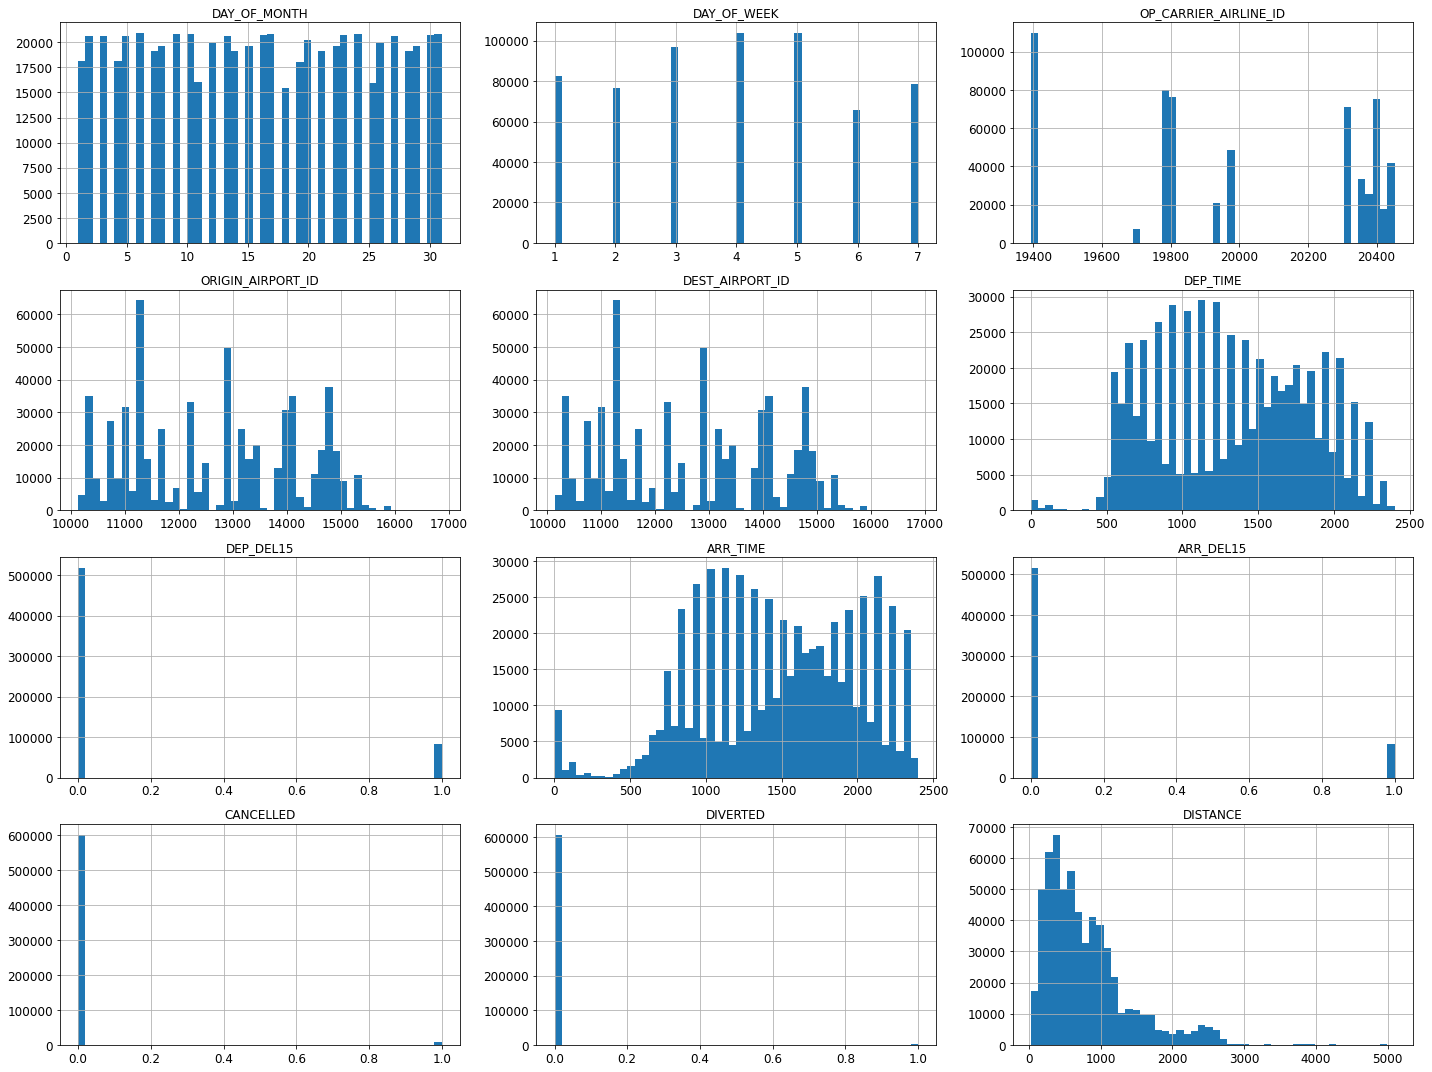

In [26]:
pysparkDF.drop('OP_CARRIER','DEST','DEST_AIRPORT_SEQ_ID','OP_UNIQUE_CARRIER', 'ORIGIN_AIRPORT_SEQ_ID', 'ORIGIN', '_c21', 'TAIL_NUM', 'OP_CARRIER_FL_NUM').toPandas().hist(bins=50, figsize=(20,15))
save_fig("attribute_histogram_plots")
plt.show()

Stacked Bar

In [28]:
# Show Count of Flights Delayed and on Time
#sumFlights = pysparkDF.groupby("DEP_DEL15").count()
#print(int(sumFlights))
# Create bars for filtered value Delayed (1) and on time (0)
ax = pysparkDF.groupby(["OP_CARRIER","DEP_DEL15"]).count.toPandas().filter(pysparkDF.DEP_DEL15 == 0).sort_values(by="OP_CARRIER",ascending=True).plot.bar(stacked=True, x="OP_CARRIER", color='Blue', label='Not Delayed')
pysparkDF.groupby(["OP_CARRIER","DEP_DEL15"]).count.toPandas().filter(pysparkDF.DEP_DEL15 == 1).sort_values(by="OP_CARRIER",ascending=True).plot.bar(stacked=True, x="OP_CARRIER", color='Orange', label='Delayed', ax=ax )


plt.ylabel("Count Flight")

save_fig("stacked_bar")
plt.show()

SyntaxError: invalid syntax (<ipython-input-28-0d1786b8bdba>, line 5)

Saving figure stacked_bar2


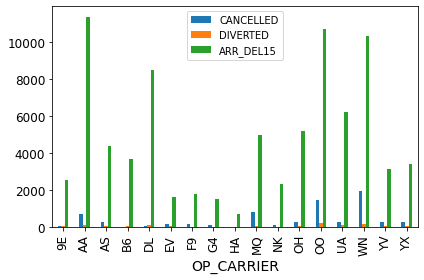

In [29]:
pandasDF.groupby(by="OP_CARRIER")[['OP_CARRIER','CANCELLED', "DIVERTED",'ARR_DEL15']].sum().plot.bar()

save_fig("stacked_bar2")
plt.show()

Bar Chart 100%

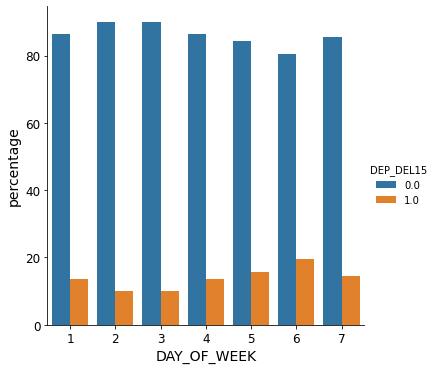

In [30]:
import matplotlib.patches as mpatches

Data=pd.read_csv('../data/Flight_Delay_Jan_2020_ontime.csv')

Data.head()

x,y = 'DAY_OF_WEEK', 'DEP_DEL15'

(Data
.groupby(x)[y]
.value_counts(normalize=True)
.mul(100)
.rename('percentage')
.reset_index()
.pipe((sns.catplot,'data'), x= 'DAY_OF_WEEK',y='percentage',hue=y, kind='bar'))
 
# show the graph
plt.show()



Pie Chart

In [31]:
#data = df.groupby("DAY_OF_WEEK").filter(df.CANCELLED==0).count()
pysparkDF.groupby("DAY_OF_WEEK", "CANCELLED").count().filter(pysparkDF.CANCELLED==1).toPandas().plot.pie(y="DAY_OF_WEEK", autopct="%.1f%%", legend=False)
plt.suptitle("Cancelled Flights", fontweight='bold')
plt.show()


SyntaxError: invalid syntax (<ipython-input-31-ee8081addaa4>, line 2)

Correlation

In [ ]:
import matplotlib.patches as mpatches

plt.figure(figsize = (12, 10))
sns.heatmap(pyspars().corr(), annot = True, cmap = 'vlag')
plt.show()

Scatter Plot

In [ ]:
ax = pysparkDF.select("OP_CARRIER_AIRLINE_ID", "ORIGIN_AIRPORT_ID").filter(pysparkDF.ARR_DEL15 != 0).toPandas().plot.scatter(x='OP_CARRIER_AIRLINE_ID', y='ORIGIN_AIRPORT_ID', color='DarkBlue', label='ARR_DEL15 1')
pysparkDF.select("OP_CARRIER_AIRLINE_ID", "ORIGIN_AIRPORT_ID").filter(pysparkDF.DEP_DEL15 != 0).toPandas().plot.scatter(x='OP_CARRIER_AIRLINE_ID', y='ORIGIN_AIRPORT_ID', color='Yellow', label='DEP_DEL15 1', ax=ax)

save_fig("scatter_plots")
plt.show()

Scatter Matrix

In [ ]:
from pandas.plotting import scatter_matrix
scatter_matrix(pysparkDF.select("OP_CARRIER_AIRLINE_ID", "ORIGIN_AIRPORT_ID", "DEST_AIRPORT_ID", "DEP_DEL15", "Distance"), alpha=0.2, figsize=(30, 30), diagonal='kde')
save_fig("scatter_matrix")
plt.show()

In [ ]:
#data = pysparkDF.groupby("DAY_OF_WEEK").filter(df.CANCELLED==0).count()
pysparkDF.groupby("DAY_OF_WEEK", "CANCELLED").count().filter(pysparkDF.CANCELLED==1).plot.pie(y="DAY_OF_WEEK", autopct="%.1f%%", legend=False)
plt.suptitle("Cancelled Flights", fontweight='bold')
plt.show()

In [ ]:
#spark.stop()